# Run NetConf on Houston IEEE data

In [1]:
# Import helper functions
# If new server on Descartes Labs, need to install rioxarray 
try: import rioxarray
except: 
    %pip install rioxarray
    
# Import helper functions
import helper_functions as hf
import netconf.netconf as nc

In [21]:
# Polygon coordinates
x1, x2, y1, y2 = 3290100, 3290200, 272900, 273000

# Data files
radarFile = './data/2018IEEE_Contest/Phase2/Lidar GeoTiff Rasters/Intensity_C3/UH17_GI3F051.tif'
labelFile = './data/2018IEEE_Contest/Phase2/TrainingGT/2018_IEEE_GRSS_DFC_GT_TR.tif'

# A priori beliefs - 2 classes green/built
decisions = {0: False, 1: True}
initBeliefs, confidence = [0.5,0.5], [0,1] # [green, built], probability of being built

# Edge creation
adjacent, geoNeighbours, phase, neighbours = False, 2, True, 3

# Classifications
targets = ['Green', 'Built']

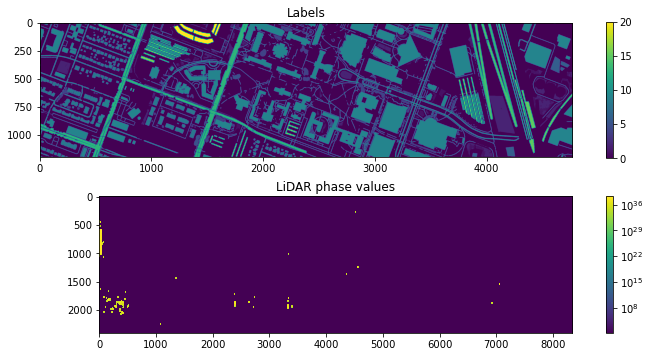

In [4]:
fig, axs = hf.create_subplots(2,1,[10,5])
hf.plot_image(labelFile, axs[0], fig, 'Labels')
hf.plot_image(radarFile, axs[1], fig, 'LiDAR phase values', log=True)
fig.tight_layout()

In [5]:
testPoly = hf.create_ipl_polygon(locations = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
labels, _ = hf.image_to_df(labelFile,'class', testPoly)
radar, _ = hf.image_to_df(radarFile,'phase', testPoly)

In [22]:
# Get geodatabase of every
initial = hf.init_beliefs(radar, columns=['green','built','phase'], crs='EPSG:6577')

geoLabels = hf.df_to_gdf(labels, columns=['class'], crs='EPSG:6577', reIndex=True)
geoLabels['class'] = hf.group_classes(geoLabels['class'], classes = [[1,7],[8,20]], zeroNan = True)

X_train, X_test, y_train, y_test = hf.train_test_split(geoLabels, column = 'class')

nodes = hf.create_nodes(initial, X_train)

# Assign prior beliefs from assessments
priors = hf.prior_beliefs(nodes, decisions, confidence, column = 'class', beliefColumns = ['green', 'built'])

# Create edges
edges = hf.create_edges(nodes, adjacent=adjacent, geo_neighbors=geoNeighbours, values=['phase'] if phase else False, neighbours=[neighbours])

In [23]:
# Run belief propagation
beliefs, _ = nc.netconf(edges,priors,verbose=True,limit=1e-7)

Nodes: 40000, Edges: 120000
It	max{del(B)}	del(label)

0	6.28112e-01		12835

1	2.27879e-01		698

2	1.06973e-01		101

3	4.63492e-02		16

4	2.09255e-02		9

5	9.38205e-03		4

6	4.20177e-03		5

7	1.90210e-03		3

8	8.52189e-04		0

9	3.86050e-04		0

10	1.73536e-04		8

11	7.83795e-05		9

12	3.52806e-05		1

13	1.59124e-05		2

14	7.16607e-06		2

15	3.22983e-06		3

16	1.45473e-06		4

17	6.55426e-07		1

18	2.95208e-07		1

19	1.32978e-07		3

20	5.98911e-08		6

Time elapsed: 124.10278916358948 seconds


              precision    recall  f1-score   support

       Green       0.76      0.80      0.78      7824
       Built       0.59      0.53      0.56      4176

    accuracy                           0.71     12000
   macro avg       0.67      0.67      0.67     12000
weighted avg       0.70      0.71      0.70     12000



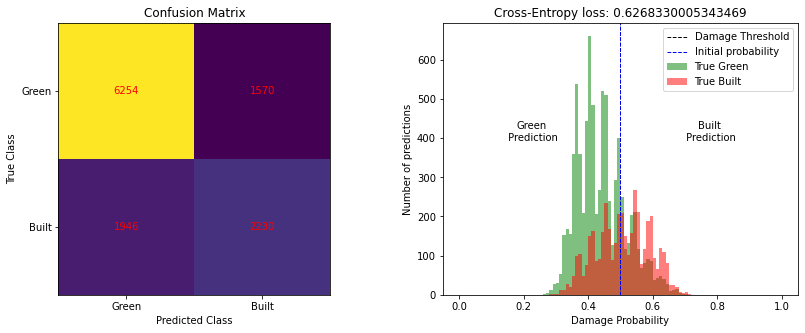

In [24]:
# Evaluation Metrics
# Get y_true vs y_pred for test set
y_true, y_pred = hf.get_labels(initial, X_test, beliefs, decisions, column='class')

# Classification metrics
yp_clf, classes = hf.class_metrics(y_true, y_pred, targets)

fig, axs = hf.create_subplots(1,2, figsize=[14,5])
# Confusion matrix
axs = hf.confusion_matrix(axs, y_true, yp_clf, classes)
  
# Cross entropy / Confidence metrics
axs = hf.cross_entropy_metrics(axs, y_true, y_pred, classes)

hf.show_plot()

In [25]:
# Save figure
hf.save_plot(fig, 'results/Houston_adj{}{}_ps{}{}'.format(str(adjacent),str(geoNeighbours),str(phase),str(neighbours)))

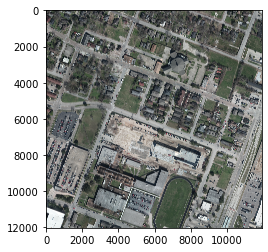

In [24]:
loc = '272056_3290290'
im = Image.open('./data/2018IEEE_Contest/Phase2/Final RGB HR Imagery/UH_NAD83_'+loc+'.tif')
plt.imshow(np.array(im))